# Plot attention map surrounding the PPIF gene

In [1]:
import pandas as pd
import bioframe as bf
import numpy as np
import seaborn as sns

import grelu.resources
import grelu.visualize
import grelu.io.genome
import grelu.interpret.score

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = grelu.resources.load_model(
    project="borzoi",
    alias="latest",
    model_name="human_fold0" 
)

wandb: Currently logged in as: anony-moose-1905623316140963. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_fold0:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


In [3]:
input_len = model.data_params["train_seq_len"]

In [4]:
input_intervals = pd.DataFrame({
    'chrom':['chr10'], 'start':[79176160], 'end':[79176160 + input_len], "strand":["+"],
})
input_start = input_intervals.start[0]
input_end = input_intervals.end[0]

In [5]:
input_seqs = grelu.sequence.format.convert_input_type(
    input_intervals,
    output_type="strings",
    genome="hg38"
)
input_seq = input_seqs[0]


In [6]:
exons = grelu.io.genome.read_gtf("hg38", features="exon")
exons = exons[exons.gene_name=="PPIF"]
gene_start = exons.start.min()
gene_end = exons.end.max()
enh_start = 79285732
enh_end = 79287386

In [7]:
attn = grelu.interpret.score.get_attention_scores(
    model=model,
    seqs=input_seq, # You can also supply just the genomic interval
    genome='hg38',
    block_idx=-1, # We take attention weights from the final transformer layer
)
attn = attn.mean(0)
attn.shape

(4096, 4096)

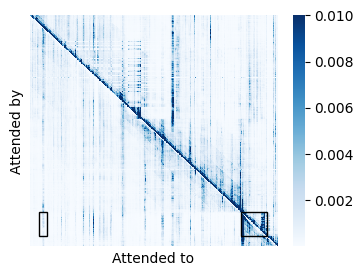

In [8]:
bin_size = 128
attn_ = attn[830:-2670, 830:-2670]
start_pos=input_start + (830*bin_size)
end_pos=input_end-(2670*bin_size)

attn_ = pd.DataFrame(attn_)

fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(attn_, vmax=0.01, xticklabels=False, yticklabels=False, cmap="Blues")

# Highlight gene
start_bin_gene = (gene_start-start_pos) // bin_size
end_bin_gene = int(np.ceil((gene_end - start_pos) / bin_size))

ax.add_patch(
    Rectangle(
        xy=[start_bin_gene, start_bin_gene],
        width=end_bin_gene - start_bin_gene,
        height=end_bin_gene - start_bin_gene,
        edgecolor="black", fill=False, linewidth=1,
    )
)

# Highlight enhancer
start_bin = (enh_start-start_pos) // bin_size
end_bin = int(np.ceil((enh_end - start_pos) / bin_size))

ax.add_patch(
    Rectangle(
        xy=[start_bin-3, start_bin_gene],
        width=end_bin + 6 - start_bin,
        height=end_bin_gene - start_bin_gene,
        edgecolor="black", fill=False, linewidth=1,
    )
)
ax.set_ylabel("Attended by")
ax.set_xlabel("Attended to")
plt.savefig('attn.png', dpi=300)

In [9]:
start_bin, end_bin

(26, 39)

In [10]:
start_bin_gene, end_bin_gene

(508, 570)

In [11]:
bin_imp_to_gene = attn_.iloc[start_bin_gene:end_bin_gene].sum(0)

In [12]:
bin_imp_to_gene.iloc[:508].argsort()[::-1].head(11)

507    154
506    153
505    143
504    320
503    386
502    129
501    195
500    319
499    387
498    321
497     34
dtype: int64

In [13]:
attn_.iloc[start_bin_gene:end_bin_gene, 34].sort_values()

566    0.000687
568    0.000721
565    0.000732
559    0.000844
554    0.000855
         ...   
530    0.005390
533    0.005661
544    0.005795
527    0.005968
528    0.007314
Name: 34, Length: 62, dtype: float32